In [8]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import seaborn as sns

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display

# # Plotly for the interactive viewer (see last section)
# import plotly.graph_objs as go

In [9]:
# Location of the training images

BASE_PATH = './input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = os.path.join(BASE_PATH, 'train_images')
mask_dir = os.path.join(BASE_PATH, 'train_label_masks')


# # Location of training labels
train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv')).set_index('image_id')
test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [3]:
display(train.head())
print("Shape of training data :", train.shape)
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


Shape of training data : (10616, 3)
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 11


In [4]:
display(test.head())
print("Shape of testing data :", test.shape)
print("unique data provider :", len(test.data_provider.unique()))

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


Shape of testing data : (3, 2)
unique data provider : 2


In [5]:
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

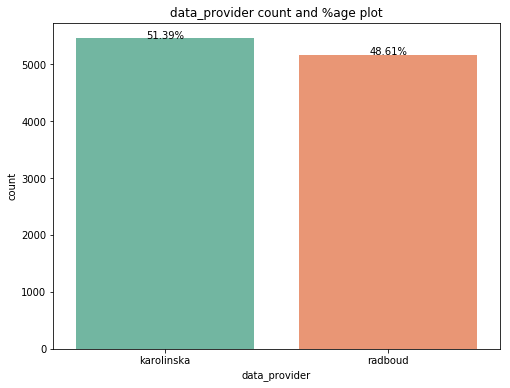

In [7]:
plot_count(df=train, feature='data_provider', title = 'data_provider count and %age plot')

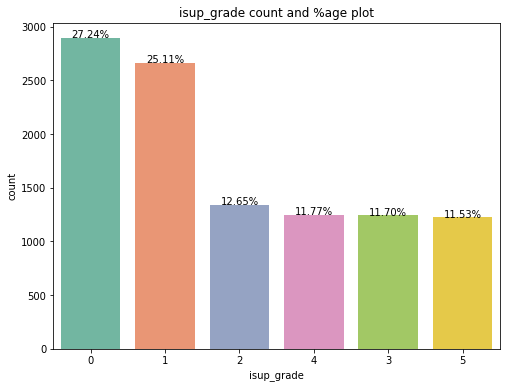

In [8]:
plot_count(df=train, feature='isup_grade', title = 'isup_grade count and %age plot')

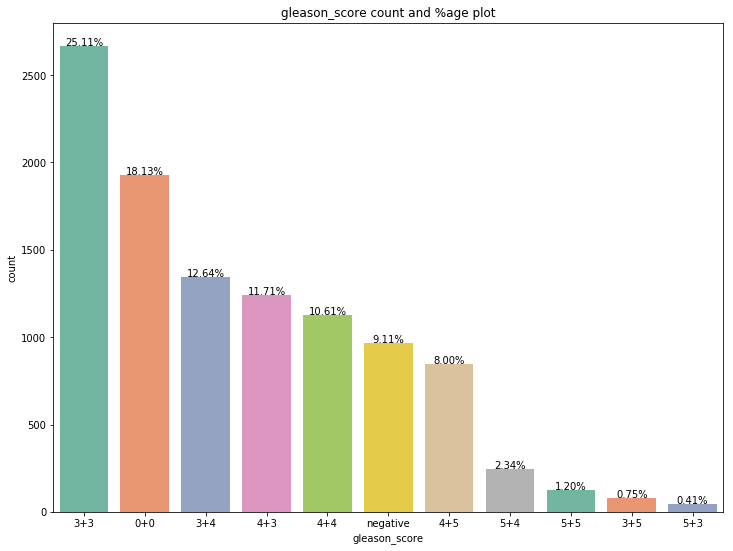

In [9]:
plot_count(df=train, feature='gleason_score', title = 'gleason_score count and %age plot', size=3)

In [10]:
def plot_relative_distribution(df, feature, hue, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    total = float(len(df))
    sns.countplot(x=feature, hue=hue, data=df, palette='Set2')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

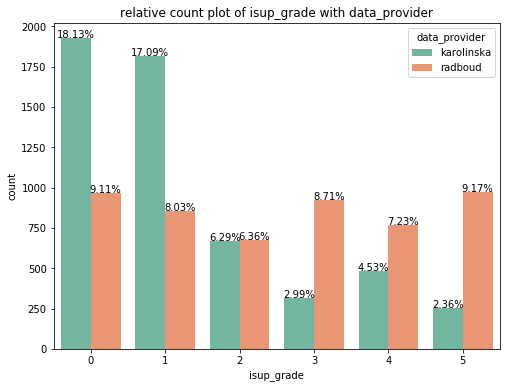

In [11]:
plot_relative_distribution(df=train, feature='isup_grade', hue='data_provider', title = 'relative count plot of isup_grade with data_provider', size=2)

In [12]:
def display_images(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        image = openslide.OpenSlide(os.path.join(data_dir, '%s.tiff'%slide))
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region((1780,1950), 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title("ID: %s\nSource: %s ISUP: %s Gleason: %s"%(image_id, 
                                 data_provider, isup_grade, gleason_score))

    plt.show() 

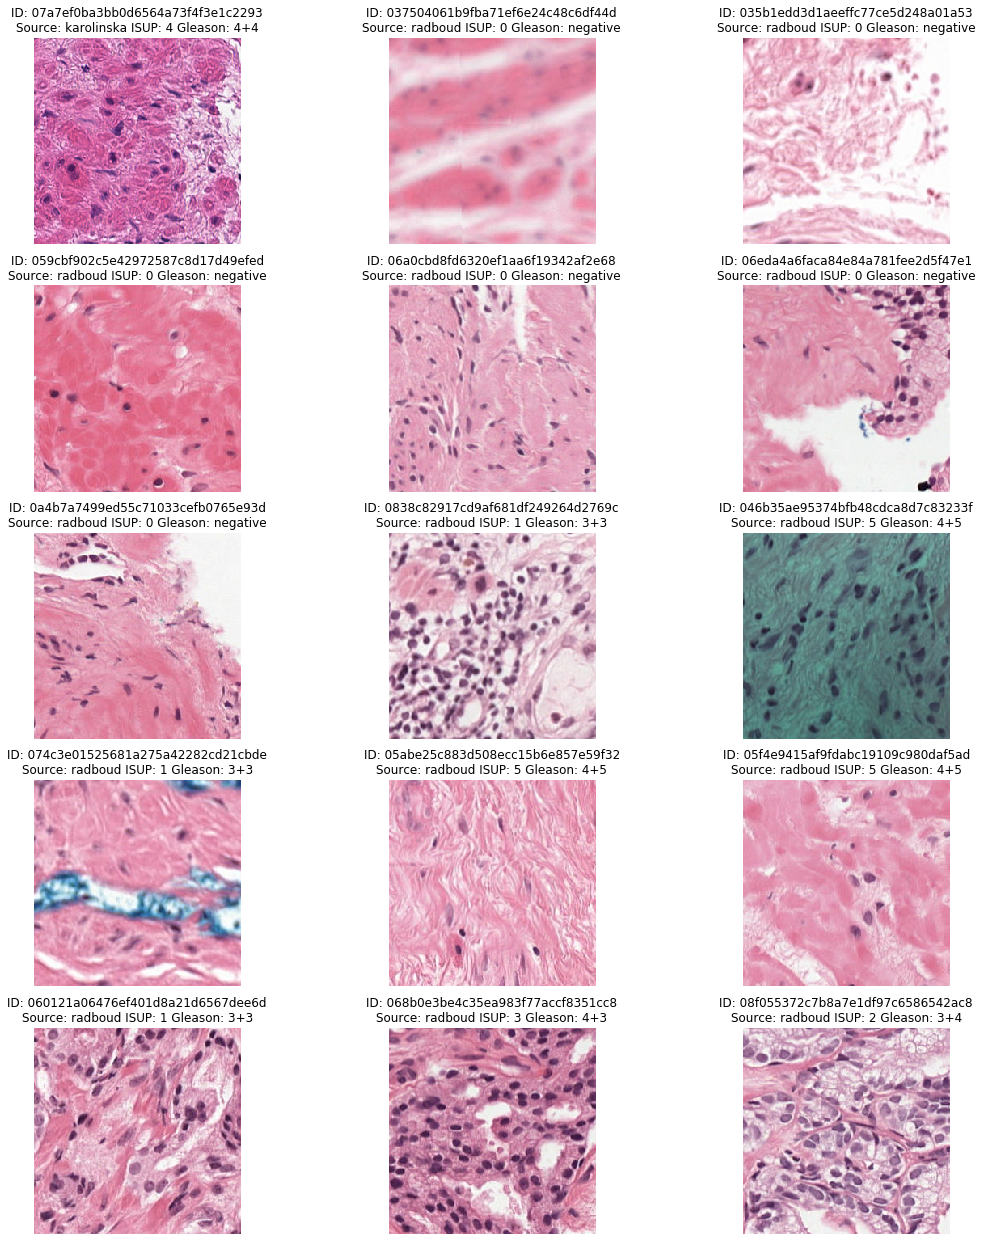

In [13]:
images = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]

display_images(images)

* The image dimensions are quite large (typically between 5.000 and 40.000 pixels in both x and y).
* Each slide has 3 levels you can load, corresponding to a downsampling of 1, 4 and 16. Intermediate levels can be created by downsampling a higher resolution level.
* The dimensions of each level differ based on the dimensions of the original image.
* Biopsies can be in different rotations. This rotation has no clinical value, and is only dependent on how the biopsy was collected in the lab.
* There are noticable color differences between the biopsies, this is very common within pathology and is caused by different laboratory procedures.

In [34]:
def display_masks(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir, '%s_mask.tiff'%slide))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[slide, 'data_provider']
        isup_grade = train.loc[slide, 'isup_grade']
        gleason_score = train.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title("ID: %s\nSource: %s ISUP: %s Gleason: %s"%(image_id,
                                data_provider, isup_grade, gleason_score))
        f.tight_layout()
        
    plt.show()

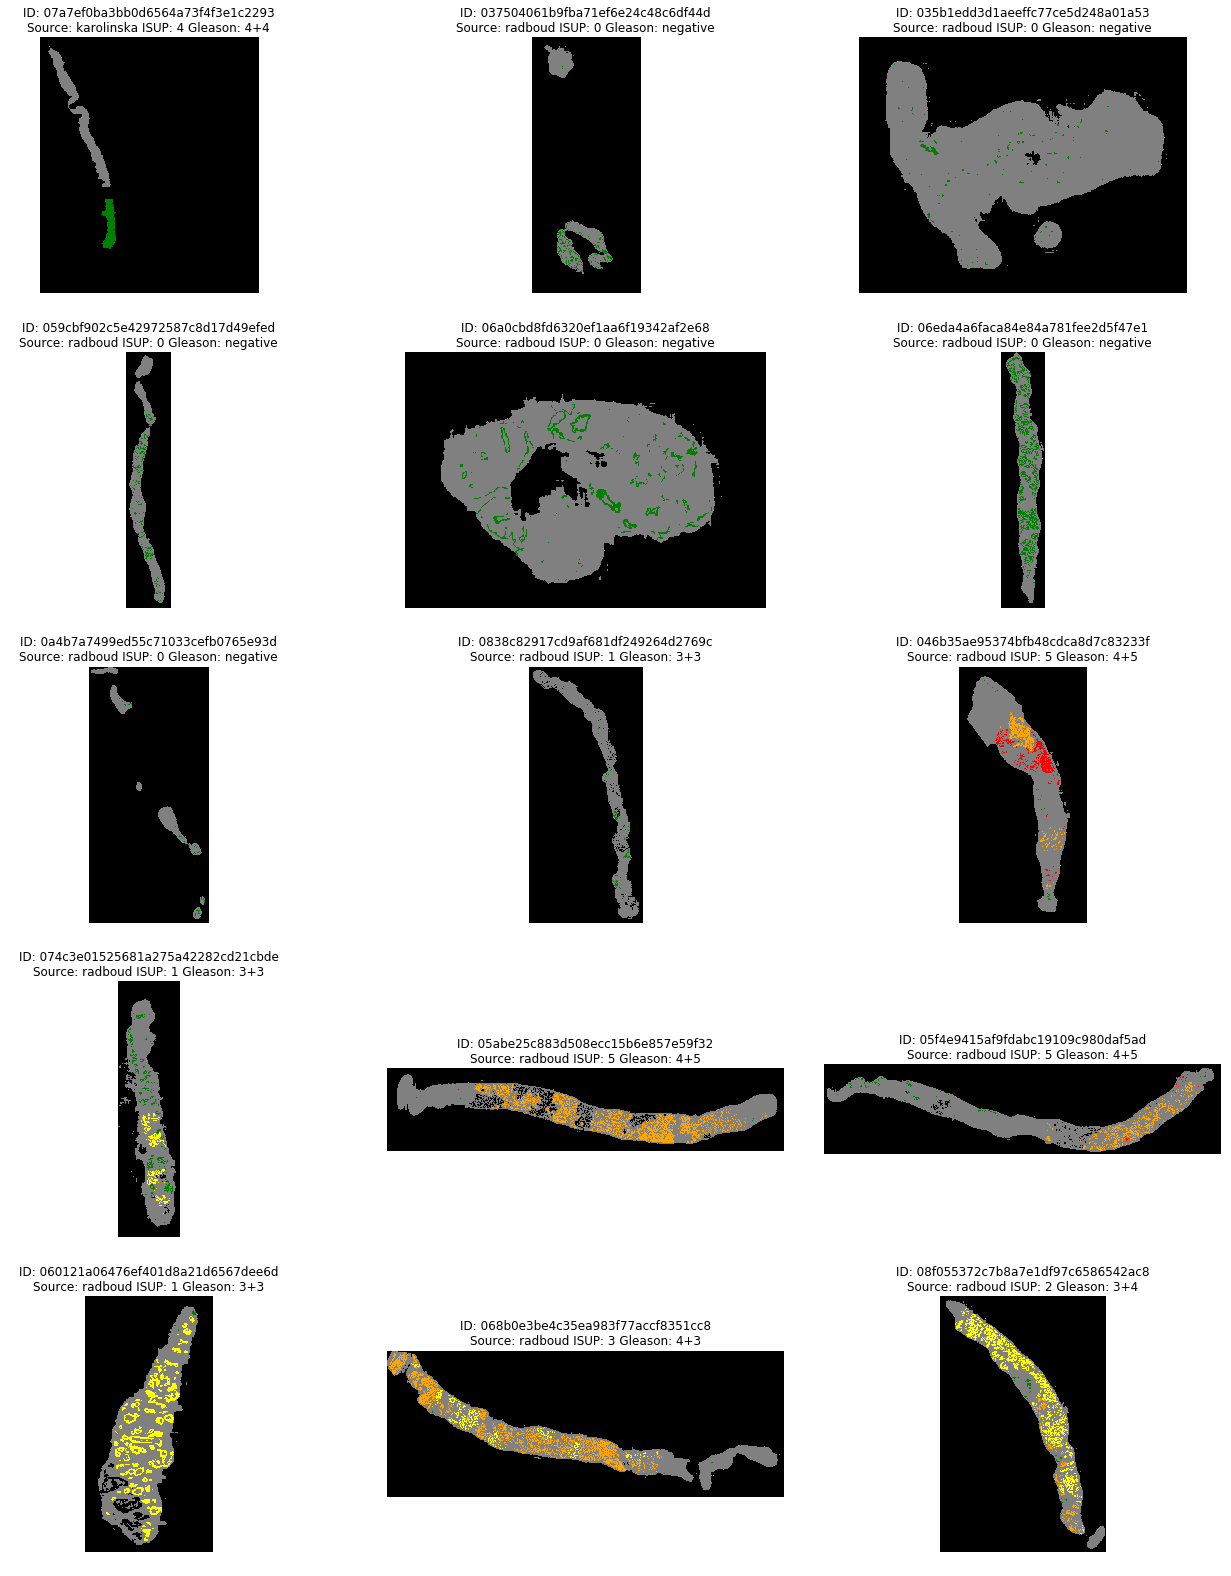

In [35]:
display_masks(images)

In [14]:
data_providers = ['karolinska', 'radboud']
train_df = pd.read_csv('%s/train.csv'%BASE_PATH)
masks = os.listdir(mask_dir)
masks_df = pd.Series(masks).to_frame()
masks_df.columns = ['mask_file_name']
masks_df['image_id'] = masks_df.mask_file_name.apply(lambda x: x.split('_')[0])
train_df = pd.merge(train_df, masks_df, on='image_id', how='outer')
del masks_df
print("There are %d images without a mask."%len(train_df[train_df.mask_file_name.isna()]))

## removing items where image mask is null
train_df = train_df[~train_df.mask_file_name.isna()]

There are 100 images without a mask.
